# Chapter 22 How to Load and Explore Human Activity Data

After completing this tutorial, you will know:
- How to download and load the dataset into memory.
- How to use line plots, histograms, and box plots to better understand the structure of the
motion data.
- How to model the problem, including framing, data preparation, modeling, and evaluation.

## 22.1 Tutorial Overview
This tutorial is divided into 10 parts; they are:
1. Activity Recognition Using Smartphones Dataset 
2. Download the Dataset
3. Load the Dataset
4. Balance of Activity Classes
5. Plot Time Series Per Subject
6. Plot Distribution Per Subject
7. Plot Distribution Per Activity
8. Plot Distribution of Activity Duration 
9. Approach to Modeling

## 22.2 Activity Recognition Using Smartphones Dataset

The six activities performed were as follows:
1. Walking
2. Walking Upstairs
3. Walking Downstairs 
4. Sitting
5. Standing
6. Laying

The movement data recorded was the **x, y, and z accelerometer data** (linear acceleration) and **gyroscopic data** (angular velocity) from the smartphone, specifically a Samsung Galaxy S II. Observations were recorded at **50 Hz** (i.e. 50 data points per second). Each subject performed the sequence of activities twice, once with the device on their left-hand-side and once with the device on their right-hand side.

The raw data is not available. Instead, a pre-processed version of the dataset was made
available. The pre-processing steps included:
- Pre-processing accelerometer and gyroscope using **noise filters**.（median filter and a 3rd order low-pass Butterworth filter with a 20 Hz cutoff frequency.）
- Splitting data into **fixed windows** of 2.56 seconds (128 data points) with **50% overlap**.
- Splitting of accelerometer data into gravitational (total) and body motion components.

## 22.3 Download the Dataset

## 22.4 Load the Dataset

In [1]:
# load one file from the har dataset
from pandas import read_csv
# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values
data = load_file('HARDataset/train/Inertial Signals/total_acc_y_train.txt')
print(data.shape)

(7352, 128)


Ideally, when working with multivariate time series data, it is useful to have the data structured in the format: [samples, timesteps, features]. 

In [ ]:
# load a list of files, such as x, y, z data for a given variable
def load_group(filenames, prefix=''): 
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = dstack(loaded)
    return loaded

We can demonstrate this function by loading all of the total acceleration files. The complete example is listed below.

In [6]:
# load group of files from the har dataset
from numpy import dstack
from pandas import read_csv

# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# load a list of files, such as x, y, z data for a given variable
def load_group(filenames, prefix=''): 
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt',
    'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt',
    'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt',
    'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt') 
    return X, y


# load all train
trainX, trainy = load_dataset('train', 'HARDataset/') 
print(trainX.shape, trainy.shape)
# load all test
testX, testy = load_dataset('test', 'HARDataset/') 
print(testX.shape, testy.shape)

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)


## 22.5 Balance of Activity Classes

In [8]:
# summarize class balance from the har dataset
from numpy import vstack
from pandas import read_csv
from pandas import DataFrame

# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# summarize the balance of classes in an output variable column
def class_breakdown(data):
    # convert the numpy array into a dataframe
    df = DataFrame(data)
    # group data by the class value and calculate the number of rows
    counts = df.groupby(0).size()
    # retrieve raw rows
    counts = counts.values
    # summarize
    for i in range(len(counts)):
        percent = counts[i] / len(df) * 100
        print('Class=%d, total=%d, percentage=%.3f' % (i+1, counts[i], percent))

if __name__ == '__main__':
    # load train file
    trainy = load_file('HARDataset/train/y_train.txt') # summarize class breakdown
    print('Train Dataset')
    class_breakdown(trainy)
    # load test file
    testy = load_file('HARDataset/test/y_test.txt') # summarize class breakdown
    print('Test Dataset')
    class_breakdown(testy)
    # summarize combined class breakdown
    print('Both')
    combined = vstack((trainy, testy)) 
    class_breakdown(combined)

Train Dataset
Class=1, total=1226, percentage=16.676
Class=2, total=1073, percentage=14.595
Class=3, total=986, percentage=13.411
Class=4, total=1286, percentage=17.492
Class=5, total=1374, percentage=18.689
Class=6, total=1407, percentage=19.138
Test Dataset
Class=1, total=496, percentage=16.831
Class=2, total=471, percentage=15.982
Class=3, total=420, percentage=14.252
Class=4, total=491, percentage=16.661
Class=5, total=532, percentage=18.052
Class=6, total=537, percentage=18.222
Both
Class=1, total=1722, percentage=16.720
Class=2, total=1544, percentage=14.992
Class=3, total=1406, percentage=13.652
Class=4, total=1777, percentage=17.254
Class=5, total=1906, percentage=18.507
Class=6, total=1944, percentage=18.876


## 22.6 Plot Time Series Per Subject

[ 1  3  5  6  7  8 11 14 15 16 17 19 21 22 23 25 26 27 28 29 30]
(302, 128, 9) (302, 1)


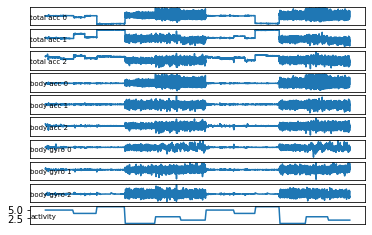

In [12]:
# plot all vars for one subject in the har dataset
from numpy import dstack
from numpy import unique
from pandas import read_csv
from matplotlib import pyplot

# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# load a list of files, such as x, y, z data for a given variable
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt',
    'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt',
    'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt',
    'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt') 
    return X, y

# get all data for one subject
def data_for_subject(X, y, sub_map, sub_id):
  # get row indexes for the subject id
  ix = [i for i in range(len(sub_map)) if sub_map[i]==sub_id]
  # return the selected samples
  return X[ix, :, :], y[ix]

# convert a series of windows to a 1D list
def to_series(windows):
    series = list()
    for window in windows:
        # remove the overlap from the window
        half = int(len(window) / 2) - 1
        for value in window[-half:]:
            series.append(value)
    return series

# plot the data for one subject
def plot_subject(X, y):
    pyplot.figure()
    # determine the total number of plots
    n, off = X.shape[2] + 1, 0
    # plot total acc
    for i in range(3):
        pyplot.subplot(n, 1, off+1)
        pyplot.plot(to_series(X[:, :, off]))
        pyplot.title('total acc '+str(i), y=0, loc='left', size=7) 
        # turn off ticks to remove clutter
        pyplot.yticks([])
        pyplot.xticks([])
        off += 1
    # plot body acc
    for i in range(3):
        pyplot.subplot(n, 1, off+1)
        pyplot.plot(to_series(X[:, :, off]))
        pyplot.title('body acc '+str(i), y=0, loc='left', size=7) 
        # turn off ticks to remove clutter
        pyplot.yticks([])
        pyplot.xticks([])
        off += 1
    # plot body gyro
    for i in range(3):
        pyplot.subplot(n, 1, off+1)
        pyplot.plot(to_series(X[:, :, off]))
        pyplot.title('body gyro '+str(i), y=0, loc='left', size=7) 
        # turn off ticks to remove clutter
        pyplot.yticks([])
        pyplot.xticks([])
        off += 1
    # plot activities
    pyplot.subplot(n, 1, n)
    pyplot.plot(y)
    pyplot.title('activity', y=0, loc='left', size=7) 
    # turn off ticks to remove clutter pyplot.yticks([])
    pyplot.xticks([])
    pyplot.show()
    
if __name__ == '__main__':
    # load data
    trainX, trainy = load_dataset('train', 'HARDataset/')
    # load mapping of rows to subjects
    sub_map = load_file('HARDataset/train/subject_train.txt') 
    train_subjects = unique(sub_map)
    
    print(train_subjects)
    # get the data for one subject
    sub_id = train_subjects[2]
    subX, suby = data_for_subject(trainX, trainy, sub_map, sub_id)
    print(subX.shape, suby.shape)
    # plot data for subject
    plot_subject(subX, suby)

## 22.7 Plot Distribution Per Subject

For a given call, a plot is created for each subject and the three variables for one data type are plotted as histograms with 100 bins, to help to make the distribution obvious. Each plot shares the same axis, which is fixed at the bounds of -1 and 1. The complete example is listed below.

<ipython-input-15-b32002b303ee>:71: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = pyplot.subplot(n, 1, k+1)


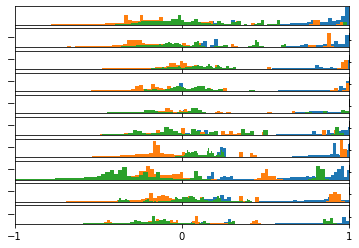

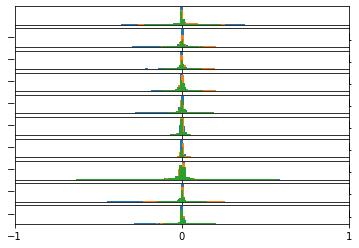

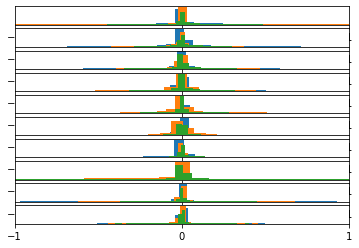

In [15]:
# plot histograms for multiple subjects from the har dataset
from numpy import unique
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot

# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# load a list of files, such as x, y, z data for a given variable
def load_group(filenames, prefix=''): 
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt',
    'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt',
    'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt',
    'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt') 
    return X, y

# get all data for one subject
def data_for_subject(X, y, sub_map, sub_id):
    # get row indexes for the subject id
    ix = [i for i in range(len(sub_map)) if sub_map[i]==sub_id]
    # return the selected samples
    return X[ix, :, :], y[ix]

# convert a series of windows to a 1D list
def to_series(windows):
    series = list()
    for window in windows:
        # remove the overlap from the window
        half = int(len(window) / 2) - 1
        for value in window[-half:]:
            series.append(value)
    return series

# plot histograms for multiple subjects
def plot_subject_histograms(X, y, sub_map, offset, n=10):
    pyplot.figure()
    # get unique subjects
    subject_ids = unique(sub_map[:,0])
    # enumerate subjects
    for k in range(n):
        sub_id = subject_ids[k]
        # get data for one subject
        subX, _ = data_for_subject(X, y, sub_map, sub_id)
        # total acc
        for i in range(3):
            ax = pyplot.subplot(n, 1, k+1)
            ax.set_xlim(-1,1)
            ax.hist(to_series(subX[:,:,offset+i]), bins=100)
            pyplot.yticks([])
            pyplot.xticks([-1,0,1])
    pyplot.show()

if __name__ == '__main__':
    # load training dataset
    X, y = load_dataset('train', 'HARDataset/')
    # load mapping of rows to subjects
    sub_map = load_file('HARDataset/train/subject_train.txt') 
    # plot total acceleration histograms for subjects 
    plot_subject_histograms(X, y, sub_map, 0)
    # plot body acceleration histograms for subjects 
    plot_subject_histograms(X, y, sub_map, 3)
    # plot gyroscopic histograms for subjects 
    plot_subject_histograms(X, y, sub_map, 6)

The first figure summarizes the total acceleration. We can see that the distribution for a given axis does appear Gaussian with large separate groups of data. We can see some of the distributions align (e.g. main groups in the middle around 0.0), suggesting there may be some continuity of the movement data across subjects, at least for this data.


The second figure shows histograms for the body acceleration with very different results. We can see all data clustered around 0.0 across axis within a subject and across subjects. This suggests that perhaps the data was centered (zero mean). This strong consistency across subjects may aid in modeling, and may suggest that the differences across subjects in the total acceleration data may not be as helpful.

Finally, a figure is generated summarizing the distribution the gyroscopic data for the first 10 subjects. We see a high likelihood of a Gaussian distribution for each axis across each subject centered on 0.0. The distributions are a little wider and show fatter tails, but this is an encouraging finding for modeling movement data across subjects.

## 22.8 Plot Distribution Per Activity

<ipython-input-18-6e92c7437eb5>:77: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = pyplot.subplot(len(activity_ids), 1, k+1)


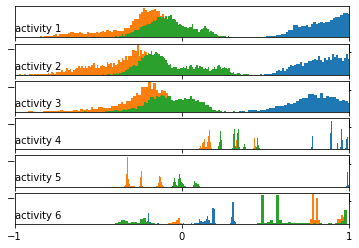

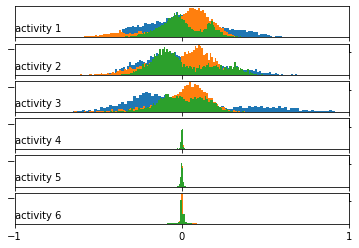

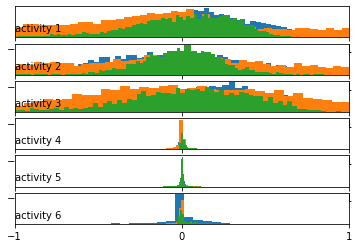

In [18]:
# plot histograms per activity for a subject from the har dataset
from numpy import dstack
from numpy import unique
from pandas import read_csv
from matplotlib import pyplot


# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# load a list of files, such as x, y, z data for a given variable
def load_group(filenames, prefix=''): 
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt',
    'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt',
    'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt',
    'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt') 
    return X, y

# get all data for one subject
def data_for_subject(X, y, sub_map, sub_id):
    # get row indexes for the subject id
    ix = [i for i in range(len(sub_map)) if sub_map[i]==sub_id]
    # return the selected samples
    return X[ix, :, :], y[ix]

# convert a series of windows to a 1D list
def to_series(windows):
    series = list()
    for window in windows:
        # remove the overlap from the window
        half = int(len(window) / 2) - 1
        for value in window[-half:]:
            series.append(value)
    return series

# group data by activity
def data_by_activity(X, y, activities):
    # group windows by activity
    return {a:X[y[:,0]==a, :, :] for a in activities}

# plot histograms for each activity for a subject
def plot_activity_histograms(X, y, offset):
    # get a list of unique activities for the subject
    activity_ids = unique(y[:,0])
     # group windows by activity
    grouped = data_by_activity(X, y, activity_ids)
    # plot per activity, histograms for each axis
    pyplot.figure()
    for k in range(len(activity_ids)):
        act_id = activity_ids[k]
        # total acceleration
        for i in range(3):
            ax = pyplot.subplot(len(activity_ids), 1, k+1) 
            ax.set_xlim(-1,1)
            # create histogra, 
            pyplot.hist(to_series(grouped[act_id][:,:,offset+i]), bins=100) # create title
            pyplot.title('activity '+str(act_id), y=0, loc='left', size=10) # simplify axis
            pyplot.yticks([])
            pyplot.xticks([-1,0,1])
    pyplot.show()
    
if __name__ == '__main__':
    # load data
    trainX, trainy = load_dataset('train', 'HARDataset/')
    # load mapping of rows to subjects
    sub_map = load_file('HARDataset/train/subject_train.txt') 
    train_subjects = unique(sub_map)
    # get the data for one subject
    sub_id = train_subjects[0]
    subX, suby = data_for_subject(trainX, trainy, sub_map, sub_id)
    # plot total acceleration histograms per activity for a subject
    plot_activity_histograms(subX, suby, 0)
    # plot body acceleration histograms per activity for a subject
    plot_activity_histograms(subX, suby, 3)
    # plot gyroscopic histograms per activity for a subject
    plot_activity_histograms(subX, suby, 6)

Running the example creates three figures, where each figure has with six subplots, one for each activity for the first subject in the train dataset. Each of the x, y, and z axes for the total acceleration data have a blue, orange, and green histogram respectively. 

In the first figure, can see that each activity has a different data distribution, with a marked difference between the large movement (first three activities) with the stationary activities (last three activities). Data distributions for the first three activities look Gaussian with perhaps differing means and standard deviations. Distributions for the latter activities look multi-modal (i.e. multiple peaks).

The second figure summarizes the body acceleration distributions per activity. We can see more similar distributions across the activities amongst the in-motion vs. stationary activities. The data looks bimodal in the case of the in-motion activities and perhaps Gaussian or exponential in the case of the stationary activities. The pattern we see with the total vs. body acceleration distributions by activity mirrors what we see with the same data types across subjects in the previous section. Perhaps the total acceleration data is the key to discriminating the activities.

The final figure summarizes the gyroscopic data per activity for the first subject. We can see plots with the similar pattern as the body acceleration data, although showing perhaps fat-tailed Gaussian-like distributions instead of bimodal distributions for the in-motion activities.

## 22.9 Plot Distribution of Activity Duration

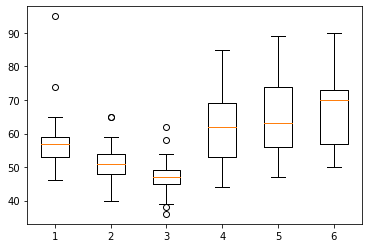

In [20]:
# plot histograms per activity for a subject from the har dataset
from numpy import dstack
from numpy import unique
from pandas import read_csv
from matplotlib import pyplot


# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# load a list of files, such as x, y, z data for a given variable
def load_group(filenames, prefix=''): 
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt',
    'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt',
    'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt',
    'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt') 
    return X, y

# get all data for one subject
def data_for_subject(X, y, sub_map, sub_id):
    # get row indexes for the subject id
    ix = [i for i in range(len(sub_map)) if sub_map[i]==sub_id]
    # return the selected samples
    return X[ix, :, :], y[ix]

# convert a series of windows to a 1D list
def to_series(windows):
    series = list()
    for window in windows:
        # remove the overlap from the window
        half = int(len(window) / 2) - 1
        for value in window[-half:]:
            series.append(value)
    return series

# group data by activity
def data_by_activity(X, y, activities):
    # group windows by activity
    return {a:X[y[:,0]==a, :, :] for a in activities}

# plot activity durations by subject
def plot_activity_durations_by_subject(X, y, sub_map):
    # get unique subjects and activities
    subject_ids = unique(sub_map[:,0])
    activity_ids = unique(y[:,0])
    # enumerate subjects
    activity_windows = {a:list() for a in activity_ids}
    for sub_id in subject_ids:
        # get data for one subject
        _, subj_y = data_for_subject(X, y, sub_map, sub_id)
        # count windows by activity
        for a in activity_ids:
            activity_windows[a].append(len(subj_y[subj_y[:,0]==a]))
    # organize durations into a list of lists
    durations = [activity_windows[a] for a in activity_ids]
    pyplot.boxplot(durations, labels=activity_ids)
    pyplot.show()
    
if __name__ == '__main__':
    # load training dataset
    X, y = load_dataset('train', 'HARDataset/')
    # load mapping of rows to subjects
    sub_map = load_file('HARDataset/train/subject_train.txt') # plot durations
    plot_activity_durations_by_subject(X, y, sub_map)

Running the example creates six box plots, one for each activity. Each box plot summarizes how long (in rows or the number of windows) subjects in the training dataset spent on each activity. We can see that the subjects spent more time on stationary activities (4, 5 and 6) and less time on the in motion activities (1, 2 and 3), with the distribution for 3 being the smallest, or where time was spent least. The spread across the activities is not large, suggesting little need to trim the longer duration activities or oversampling of the in-motion activities. Although, these approaches remain available if skill of a predictive model on the in-motion activities is generally worse.

## 22.10 Approach to Modeling

In this section, we summarize some approaches to modeling the activity recognition dataset. These ideas are divided into the main themes of a project.

### 22.10.1 Problem Framing

The first important consideration is the framing of the prediction problem. The framing of the problem as described in the original work is the prediction of activity for a new subject given their movement data, based on the movement data and activities of known subjects. We can summarize this as:
- Predict activity given a window of movement data.

This is a reasonable and useful framing of the problem. Some other possible ways to frame the provided data as a prediction problem include the following:



- Predict activity given a time step of movement data.
- Predict activity given multiple windows of movement data.
- Predict the activity sequence given multiple windows of movement data.
- Predict activity given a sequence of movement data for a pre-segmented activity.
- Predict activity cessation（停止） or transition（过渡） given a time step of movement data.
- Predict a stationary or non-stationary activity given a window of movement data.

Some of these framings may be too challenging or too easy. Nevertheless, these framings provide additional ways to explore and understand the dataset.

### 22.10.2 Data Preparation
Some data preparation may be required prior to using the raw data to train a model. The data already appears to have been scaled to the range [-1,1]. Some additional data transforms that could be performed prior to modeling include:
- Normalization across subjects. 􏰀 Standardization per subject.
- Standardization across subjects. 􏰀 Axis feature selection.
- Data type feature selection.
- Signal outlier detection and removal.
- Removing windows of over-represented activities.
- Oversampling windows of under-represented activities.
- Downsampling signal data to $\frac{1}{4}$, $\frac{1}{2}$ , 1, 2 or other fractions of a section.


### 22.10.3 Predictive Modeling

Generally, the problem is a time series multiclass classification problem. As we have seen, it may also be framed as a binary classification problem and a multi-step time series classification problem. The original paper explored the use of a classical machine learning algorithm on a version of the dataset where features were engineered from each window of data. Specifically, a modified support vector machine.

The results of an SVM on the feature-engineered version of the dataset may provide a baseline in performance on the problem. Expanding from this point, the evaluation of multiple linear, nonlinear, and ensemble machine learning algorithms on this version of the dataset may provide an improved benchmark. The focus of the problem may be on the un-engineered or raw version of the dataset. Here, a progression in model complexity may be explored in order to determine the most suitable model for the problem; some candidate models to explore include:

- Common linear, nonlinear, and ensemble machine learning algorithms. 
- Multilayer Perceptron.
- Convolutional neural networks, specifically 1D CNNs.
- Recurrent neural networks, specifically LSTMs.
- Hybrids of CNNs and LSTMs such as the CNN-LSTM and the ConvLSTM.

## 22.11 Model Evaluation

The evaluation of the model in the original paper involved using a train/test split of the data by subject with a 70% and 30% ratio. Exploration of this pre-defined split of the data suggests that both sets are reasonably representative of the whole dataset. Another alternative methodology may be to use leave-one-out cross-validation, or LOOCV, per subject. In addition to giving the data for each subject the opportunity for being used as the withheld test set, the approach would provide a population of 30 scores that can be averaged and summarized, which may offer a more robust result.

Model performance was presented using classification accuracy and a confusion matrix, both of which are suitable for the multiclass nature of the prediction problem. Specifically, the confusion matrix will aid in determining whether some classes are easier or more challenging to predict than others, such as those for stationary activities versus those activities that involve motion.

## 22.12 Extensions
This section lists some ideas for extending the tutorial that you may wish to explore.
- List Intuitions. Outline the method that you believe may be most effective in making forecasts with on this dataset.
- Apply Taxonomy. Use the taxonomy in Chapter 2 to describe the dataset presented in this chapter.
- Additional Analysis. Use summary statistics and/or plots to explore one more aspect of the dataset that may provide insight into modeling this problem.
